In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=True, samp_freq=samp_freq)

In [5]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=True, samp_freq=samp_freq)

In [6]:
# load kilosort units that passed ibl's quality metrics
good_ks_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi='all', keep_active_trials = True, samp_freq=30_000)

In [7]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [8]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


initialize gmm using k-means++ (recommended and faster than k-means)

In [9]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [10]:
initial_gmm = init_gmm.initial_gaussian_mixtures('.', sub_id, trials, n_gaussians=350, seed=seed, fit_model=True)

In [11]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

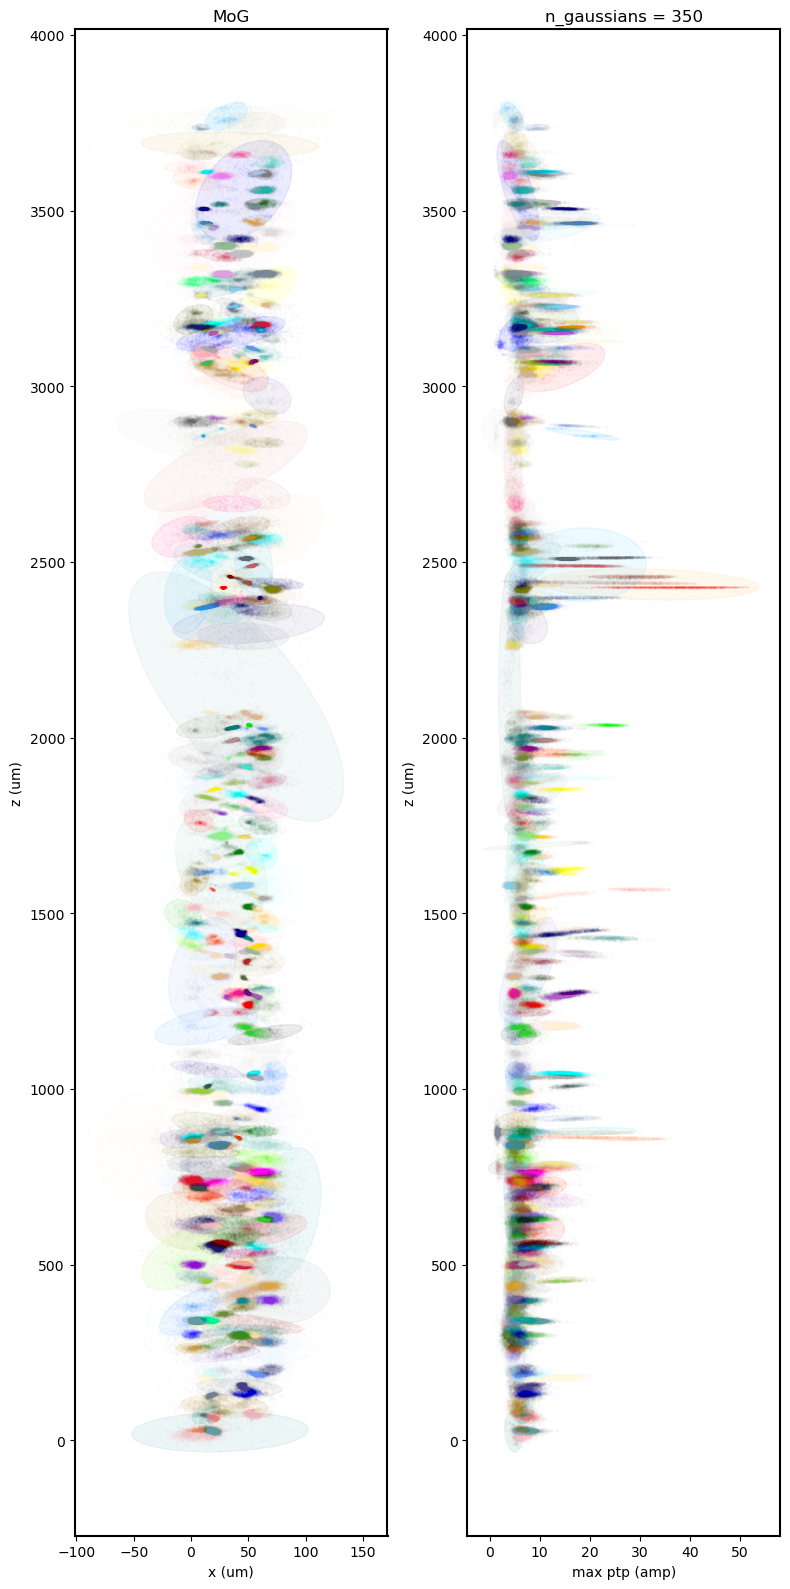

In [12]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, initial_labels, n_spikes_display=10_000)

split

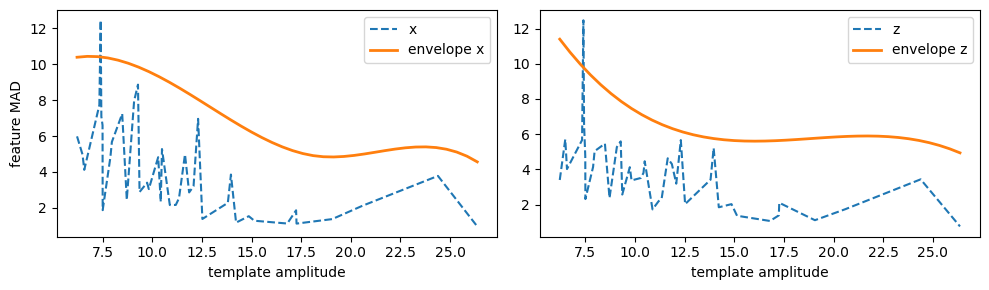

In [13]:
# plot smooth envelope for kilosort template feature MADs

split_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)

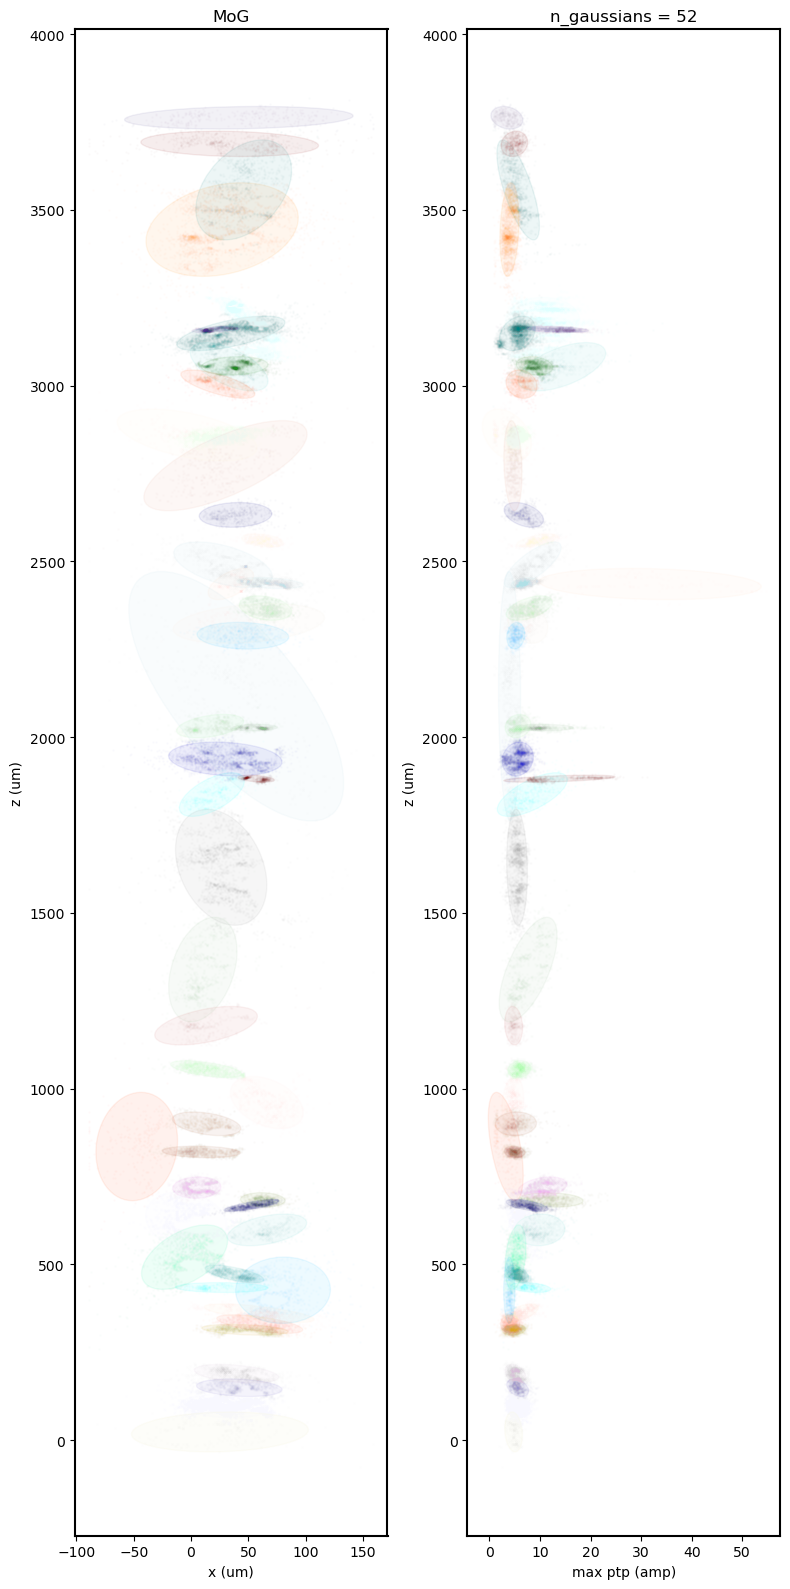

In [14]:
# plot gaussians to be split

viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, split_ids, n_spikes_display=10_000)

In [ ]:
post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, init_method='k-means++', fit_model=True)

initial n_gaussians: 350 bic: 13976060.44
keep 298 gaussians and split 52 gaussians ...
pre-split bic: 14440592.3
split gaussian 4 into 2 gaussians with updated bic: 14386171.2
split gaussian 4 into 3 gaussians with updated bic: 14392592.15
split gaussian 6 into 2 gaussians with updated bic: 14305711.69
split gaussian 6 into 3 gaussians with updated bic: 14314474.39
split gaussian 9 into 2 gaussians with updated bic: 14291266.44
split gaussian 9 into 3 gaussians with updated bic: 14291454.39
split gaussian 10 into 2 gaussians with updated bic: 14223505.77
split gaussian 10 into 3 gaussians with updated bic: 14227399.74
split gaussian 12 into 2 gaussians with updated bic: 14181176.58
split gaussian 12 into 3 gaussians with updated bic: 14186738.65
split gaussian 33 into 2 gaussians with updated bic: 14081829.11
split gaussian 33 into 3 gaussians with updated bic: 14087640.57


merge